The basic idea is to find out which categories of genomic regions (exons, promoters, enhancers, etc) contribute the most to the Nea. ancestry observed in present day Europeans. For example: have coding regions or enhancers been the main drivers of selection against Nea. introgression?

Links:

* info about different coordinate types: https://groups.google.com/forum/#!msg/biomart-users/OtQbAx3y9CA/wrF19ID1AgAJ
* https://www.biostars.org/p/2005/
* http://www.bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/biomaRt.html#attribute-pages
* http://www.ensembl.org/info/data/biomart/biomart_r_package.html
* http://www.ensembl.info/blog/2015/06/01/biomart-or-how-to-access-the-ensembl-data-from-r/
* for checking with manually downloaded data: http://www.ensembl.org/info/data/biomart/how_to_use_biomart.html
* biotypes FAQ: http://www.ensembl.org/Help/Glossary

Following [this](http://www.ensembl.org/info/data/biomart/biomart_r_package.html) tutorial, I want to extract coordinates of exonic and regulatory regions from the Ensembl database and then calculate the density of such regions in a defined window around each SNP.

These densities will they be used as predictors in a linear model, predicting the Nea. ancestry at each site.

Alternatively, I could just test if the distribution of densities for different regions differ based on frequency of Nea. alleles at each site.

# Fetch coordinates of different genomic regions

In [1]:
suppressMessages(suppressWarnings({
    library(biomaRt)
    library(rtracklayer)
    library(BSgenome.Hsapiens.UCSC.hg19)
}))

In [2]:
suppressMessages(suppressWarnings({
    library(tidyverse)
    library(stringr)
    library(magrittr)
}))

In [3]:
regions <- list()

## Protein coding and UTR coordinates

Show all the available biomarts for hg19:

In [4]:
listMarts(host="grch37.ensembl.org")

biomart              version              
1 ENSEMBL_MART_ENSEMBL Ensembl Genes 90     
2 ENSEMBL_MART_SNP     Ensembl Variation 90 
3 ENSEMBL_MART_FUNCGEN Ensembl Regulation 90

Connect to the human gene Ensembl dataset:

In [5]:
ensembl_mart_genes <- useMart("ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org")
listDatasets(ensembl_mart_genes) %>% filter(str_detect(dataset, "sapiens"))

dataset               description              version   
1 hsapiens_gene_ensembl Human genes (GRCh37.p13) GRCh37.p13

In [6]:
genes <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl_mart_genes)

### Protein coding coordinates

In [7]:
regions[["protein_coding"]] <-
    getBM(c("chromosome_name", "genomic_coding_start", "genomic_coding_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    select(chrom=chromosome_name, start=genomic_coding_start, end=genomic_coding_end) %>%
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [8]:
sum(width(regions[["protein_coding"]]))

[1] 33844885

### UTRs


More on the UTR vs protein_coding sizes in humans:
* http://seqanswers.com/forums/showthread.php?p=34995#post34995
* http://www.nature.com/nature/journal/v461/n7261/full/nature08250.html


Also: https://groups.google.com/forum/#!topic/biomart-users/OtQbAx3y9CA

#### 5' UTR

In [9]:
regions[["utr5"]] <-
    getBM(c("chromosome_name", "5_utr_start", "5_utr_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    setNames(c("chrom", "start", "end")) %>% 
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [10]:
sum(width(regions[["utr5"]]))

[1] 10336680

#### 3' UTR

In [11]:
regions[["utr3"]] <-
    getBM(c("chromosome_name", "3_utr_start", "3_utr_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    setNames(c("chrom", "start", "end")) %>% 
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [12]:
sum(width(regions[["utr3"]]))

[1] 37469434

## Get the coordinates of 5kb upstream of transcription start site

Make sure to correctly handle 5k upstream (on the fwd strand) ond 5k downstream (ond the rev strand) from the TSS.

In [13]:
listFilters(genes) %>% filter(str_detect(name, "biotype"))

name               description    
1 biotype            Type           
2 transcript_biotype Transcript Type

In [14]:
tss <-
    getBM(c("chromosome_name", "transcription_start_site", "strand"),
          filters=c("chromosome_name", "transcript_biotype"),
          values=list(1:22, "protein_coding"),
          mart=genes) %>%
    setNames(c("chrom", "pos", "strand")) %>% 
    mutate(strand=ifelse(strand == 1, "-", "+")) %>% 
    arrange(chrom, pos) %>%
    makeGRangesFromDataFrame(start.field="pos", end.field="pos")

In [15]:
regions[["tss_5k"]] <- resize(tss, width=5001)
strand(regions[["tss_5k"]]) <- "*"
regions[["tss_5k"]] %<>% IRanges::reduce()

## Coordinates of regulatory features

It took forever to find out, how to get the regulatory features. In the end I found it totally by accident in some bugreport mail :( https://support.bioconductor.org/p/39545/

Show all the available biomarts for hg19:

In [16]:
listMarts(host="grch37.ensembl.org")

biomart              version              
1 ENSEMBL_MART_ENSEMBL Ensembl Genes 90     
2 ENSEMBL_MART_SNP     Ensembl Variation 90 
3 ENSEMBL_MART_FUNCGEN Ensembl Regulation 90

Connect to the human gene Ensembl dataset:

In [17]:
ensembl_mart_funcgen <- useMart("ENSEMBL_MART_FUNCGEN", host="grch37.ensembl.org")
listDatasets(ensembl_mart_funcgen) %>% filter(str_detect(dataset, "sapiens"))

dataset                       description                                
1 hsapiens_annotated_feature    Human Regulatory Evidence (GRCh37.p13)     
2 hsapiens_motif_feature        Human Binding Motifs (GRCh37.p13)          
3 hsapiens_mirna_target_feature Human miRNA Target Regions (GRCh37.p13)    
4 hsapiens_regulatory_feature   Human Regulatory Features (GRCh37.p13)     
5 hsapiens_external_feature     Human Other Regulatory Regions (GRCh37.p13)
  version   
1 GRCh37.p13
2 GRCh37.p13
3 GRCh37.p13
4 GRCh37.p13
5 GRCh37.p13

In [18]:
regulation <- useDataset(dataset="hsapiens_regulatory_feature", mart=ensembl_mart_funcgen)

Download the dataframe from Biomart:

In [19]:
regulatory_features_df <-
    getBM(attributes=c("chromosome_name", "chromosome_start", "chromosome_end", "feature_type_name"),
          filters="chromosome_name",
          values=1:22,
          mart=regulation) %>%
    setNames(c("chrom", "start", "end", "feature")) %>%
    mutate(feature=str_replace_all(tolower(feature), " ", "_"),
           feature=str_replace(feature, "flanking_region", "flank"))

In [20]:
table(regulatory_features_df$feature)


ctcf_binding_site          enhancer    open_chromatin          promoter 
            55194             27577            107233             14287 
   promoter_flank   tf_binding_site 
            45496             22376 

In [21]:
regions <- c(regions, lapply(split(regulatory_features_df, regulatory_features_df$feature),
                             function(df) {
                                 IRanges::reduce(makeGRangesFromDataFrame(df))
                             }))

## Coordinates of primate phastCons elements

How to retrieve them: https://support.bioconductor.org/p/25587/

Per-base vs elements diference: https://www.biostars.org/p/2129/#2143

In [22]:
library(rtracklayer)

In [23]:
session <- browserSession()
genome(session) <- "hg19"

In [24]:
query <- ucscTableQuery(session, "cons46way", GRangesForUCSCGenome("hg19", chrom=paste0("chr", 1:22)))

In [25]:
tableNames(query)

[1] "phyloP46wayPrimates"             "phyloP46wayPlacental"           
 [3] "phyloP46wayAll"                  "phastCons46wayPrimates"         
 [5] "phastCons46wayPlacental"         "phastCons46way"                 
 [7] "phastConsElements46wayPrimates"  "phastConsElements46wayPlacental"
 [9] "phastConsElements46way"          "multiz46way"

In [26]:
tableName(query) <- "phastConsElements46wayPrimates"

In [27]:
regions[["priPhastCons"]] <-
    getTable(query) %>%
    select(-bin, -name, -score) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE)

Keep only those priPhastCons-infered regions that do not overlap anything else:

## Reduce all regions and convert their coordinates to UCSC hg19

Convert all coordinate dataframes into individual `GRanges` objects:

In [28]:
regions <- lapply(regions,
                  function(r) {
                      reduced_r <- IRanges::reduce(r)
                      seqlevelsStyle(reduced_r) <- "UCSC"
                      seqinfo(reduced_r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
                      
                      reduced_r
                  })

## Get a set of phastCons conserved regions that do not overlap anything else

## Get coordinates of all putatively non-functional regions

First get the reduce set of annotated regions (everything mashed together):

In [29]:
(all_regions <- unlist(GRangesList(regions)) %>% IRanges::reduce() %>% sort)

GRanges object with 751323 ranges and 0 metadata columns:
           seqnames               ranges strand
              <Rle>            <IRanges>  <Rle>
       [1]     chr1       [ 9880, 10734]      *
       [2]     chr1       [11001, 11800]      *
       [3]     chr1       [13371, 13724]      *
       [4]     chr1       [13908, 14498]      *
       [5]     chr1       [15462, 15778]      *
       ...      ...                  ...    ...
  [751319]    chr22 [51221197, 51227091]      *
  [751320]    chr22 [51231014, 51231196]      *
  [751321]    chr22 [51235000, 51235201]      *
  [751322]    chr22 [51237212, 51237544]      *
  [751323]    chr22 [51239150, 51239664]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

Get lengths of all hg19 chromosomes:

In [30]:
hg19 <- GRanges(seqinfo(BSgenome.Hsapiens.UCSC.hg19))
hg19 <- hg19[seqnames(hg19) %in% paste0("chr", 1:22)]

Everything in hg19 that is not in the annotated set of functional regions is a gap or "junk":

In [31]:
regions[["gap"]] <- IRanges::setdiff(hg19, all_regions) %>% IRanges::reduce() %>% sort

### Total amount of sequence in each genomic region

In [32]:
tibble(
    region=names(regions),
    length=sapply(regions, function(r) { sum(as.numeric(width(IRanges::reduce(r))))} ) / 1e6
) %>% arrange(length)

region            length    
1  utr5                10.33668
2  tf_binding_site     10.48753
3  enhancer            18.27491
4  promoter            22.68667
5  protein_coding      33.84488
6  utr3                37.46943
7  ctcf_binding_site   41.23060
8  open_chromatin      51.20425
9  promoter_flank      59.75196
10 priPhastCons       101.02500
11 tss_5k             157.46965
12 gap               2449.85019

In [49]:
saveRDS(regions, "../data/RData/introgression_predictors_regions.rds")

<br><br><br><br><br><br><br><br><br><br>

## Get coordinates of admixture array sites

* Add intergenic regions too - actually, regions are not necessary, just takes SNPs that don't overlap anything.
* Check how many admixture array sites fall within each functional region.

In [33]:
source("../R/utils.R")

In [34]:
suppressMessages({

# load the sample information
sgdp <- load_sgdp_info("../data/10_24_2014_SGDP_metainformation_update.txt") %>%
    filter(! Region %in% c("Africa", "Oceania")) %>%
    dplyr::select(-Country, -Latitude, -Longitude, pop=Region) %>%
    mutate(age=0) %>%
    group_by(name, age, pop) %>%
    ungroup
emhs <- read_delim("../data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
    mutate(name=str_replace(name, "-", "_"), pop="EMH", Latitude=NA, Longitude=NA) %>%
    filter(name != "Oase1")
samples <- bind_rows(emhs, sgdp)

# load genotypes at archaic admixture sites
genotypes <-
    load_dataset("../data/genotypes/ice_age.tsv",
                 "../data/genotypes/sgdp.tsv",
                 "../data/genotypes/archaics.tsv",
                 random_sample=FALSE) %>%
    select(c("chrom", "pos", sgdp$name)) %>%
    mutate(start=pos, end=pos) %>%
    select(-pos) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

})

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [35]:
seqlevelsStyle(genotypes) <- "UCSC"
seqinfo(genotypes) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

In [36]:
sites <- granges(genotypes)

## Calculate Neanderthal allele frequency at each locus

In [37]:
freq_eur <- 1/2 * apply(mcols(genotypes)[filter(samples, pop == "WestEurasia")$name], 1, mean, na.rm=TRUE)
freq_all <- 1/2 * apply(mcols(genotypes)[filter(samples, pop != "EMH")$name], 1, mean, na.rm=TRUE)

In [38]:
mcols(sites)[["freq_eur"]] <- freq_eur
mcols(sites)[["freq_all"]] <- freq_all

In [39]:
summary(sites$freq_eur)
summary(sites$freq_all)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.01830 0.01493 1.00000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.002538 0.020440 0.020300 1.000000 

## Get the hits of each site in different genomic regions

In [40]:
for (r in names(regions)) {
    col_name <- paste0("hits_", r)

    # find which sites are falling within a given region
    hits <- findOverlaps(sites, regions[[r]])

    # mark which sites hit a region
    mcols(sites)[[col_name]] <- 0
    mcols(sites[queryHits(hits)])[[col_name]] <- 1
}

## Add B value to each locus

In [41]:
source("../R/assign_bvals.R")


Attaching package: ‘BSgenome.Hsapiens.UCSC.hg18’

The following object is masked from ‘package:BSgenome.Hsapiens.UCSC.hg19’:

    Hsapiens



In [42]:
sites <- assign_bvals(sites, bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain")

## Number of admixture array sites in each genomic region

In [43]:
sapply(regions, function(reg) { length(IRanges::subsetByOverlaps(sites, reg)) }) %>% sort

tf_binding_site              utr5          enhancer    protein_coding 
             2257              2391              4020              4953 
         promoter              utr3 ctcf_binding_site    open_chromatin 
             5189              6821              8518             11158 
   promoter_flank      priPhastCons            tss_5k               gap 
            13208             17443             27598            400872

## Convert the final `GRanges` object to a normal data frame for the analyses bellow

In [44]:
tbl <- as.data.frame(sites) %>%
    select(-width, -strand) %>%
    rename(chrom=seqnames) %>%
    filter(complete.cases(.))

In [45]:
nrow(tbl)

[1] 483864

<br><br><br><br><br>

## Modeling the dependence of Nea. frequency on functional predictors

In [53]:
summary(fit <- glm(data=tbl, freq_all > 0 ~ hits_protein_coding + hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ hits_protein_coding + hits_utr5 + 
    hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + 
    hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + 
    hits_tf_binding_site, family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.238  -1.192   1.153   1.163   1.328  

Coefficients:
                        Estimate Std. Error z value             Pr(>|z|)    
(Intercept)             0.034008   0.003089  11.009 < 0.0000000000000002 ***
hits_protein_coding    -0.048072   0.028902  -1.663             0.096258 .  
hits_utr5              -0.055135   0.043663  -1.263             0.206682    
hits_utr3              -0.090377   0.024617  -3.671             0.000241 ***
hits_tss_5k            -0.088652   0.012867  -6.890     0.00000000000558 ***
hits_promoter          -0.146750   0.030273  -4.848     0.00000124989234 ***
hits_promoter_flank    -0.062049   0.017737  -3.498             0.000468 **

In [54]:
summary(fit <- glm(data=tbl, freq_all > 0 ~ hits_priPhastCons + hits_protein_coding + hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ hits_priPhastCons + hits_protein_coding + 
    hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_promoter_flank + 
    hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + 
    hits_tf_binding_site, family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.242  -1.193   1.152   1.162   1.334  

Coefficients:
                        Estimate Std. Error z value             Pr(>|z|)    
(Intercept)             0.037271   0.003121  11.944 < 0.0000000000000002 ***
hits_priPhastCons      -0.118220   0.015989  -7.394    0.000000000000143 ***
hits_protein_coding     0.003926   0.029755   0.132             0.895023    
hits_utr5              -0.048400   0.043680  -1.108             0.267836    
hits_utr3              -0.081013   0.024654  -3.286             0.001016 ** 
hits_tss_5k            -0.088991   0.012868  -6.916    0.000000000004655 ***
hits_promoter          -0.142084   0.030283  -4.692    

<br><br><br><br><br>

In [48]:
save.image("../data/RData/introgression_predictors.RData")

<br><br><br><br><br>

## Neanderthal ancestry proportions at sites in different functional regions

Join the tables of SGDP genotypes and hits of SNPs in different regions:

In [55]:
sample_ids <- filter(samples, pop != "EMH")$name

Calculate Nea. ancestry in each individual in different regions of the genome:

In [ ]:
nea_in_regions <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    gather(region, hits, -c(1:3), -c(S_Chane_1:S_Yemenite_Jew_2)) %>%
    select(-seqnames, -start, -end) %>%
    gather(name, gt, -region, -hits) %>%
    group_by(name, region, hits) %>%
    summarise(nea=mean(gt, na.rm=TRUE) / 2) %>%
    ungroup %>% 
    mutate(hits=factor(hits),
           region=str_replace(region, "hits_", ""))

Joining, by = c("seqnames", "start", "end")


In [ ]:
gc()

In [ ]:
genome_nea <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    summarise_at(sample_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    t %>% .[, 1]

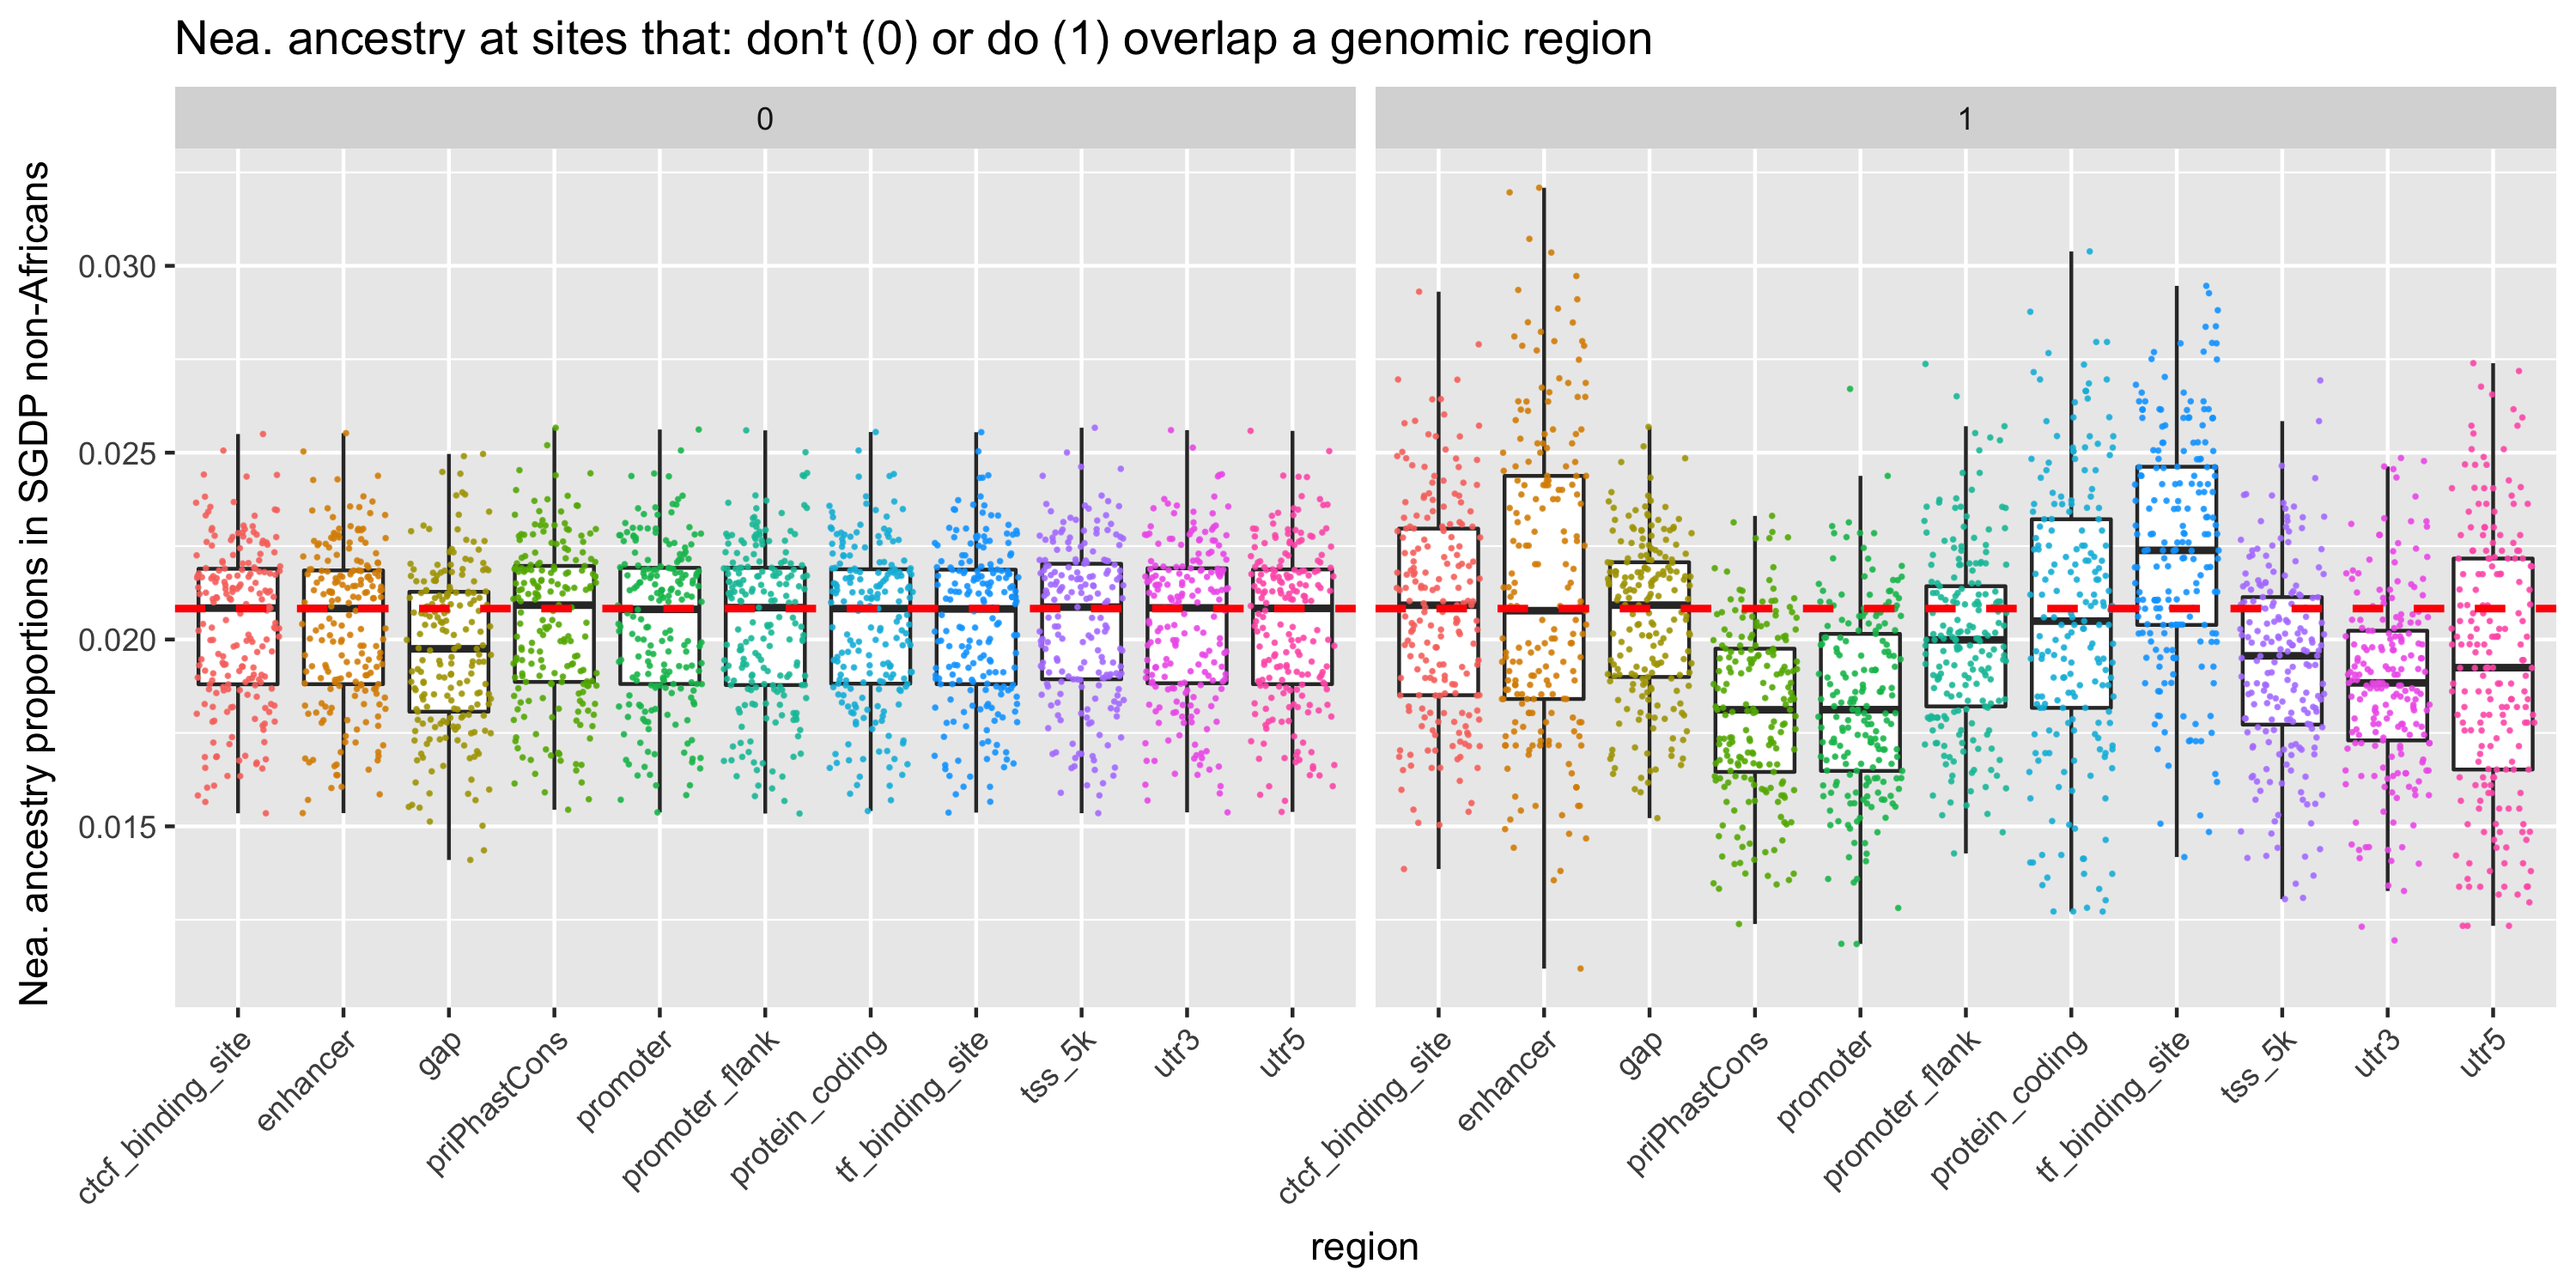

In [57]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

nea_in_regions %>%
filter(complete.cases(.)) %>% 
ggplot(aes(region, nea)) +
    geom_boxplot(outlier.size=NA) +
    geom_jitter(aes(color=region), size=0.2, alpha=0.8) +
    geom_hline(yintercept=median(genome_nea), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region") +
    labs(y="Nea. ancestry proportions in SGDP non-Africans ", "genomic region")

<br><br><br><br><br>
## Neanderthal ancestry proportions at sites in different _unique_ functional regions

Join the tables of SGDP genotypes and hits of SNPs in different regions:

In [67]:
sample_ids <- filter(samples, pop != "EMH")$name

In [68]:
unique_sites <- (as.data.frame(sites) %>% select(starts_with("hits")) %>% rowSums) %>% {. == 1 & !is.na(.) }

In [69]:
sum(unique_sites)

[1] 446679

Calculate Nea. ancestry in each individual in different regions of the genome:

In [70]:
nea_in_uniq_regions <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    filter(unique_sites) %>%
    gather(region, hits, -c(1:3), -c(S_Chane_1:S_Yemenite_Jew_2)) %>%
    select(-seqnames, -start, -end) %>%
    gather(name, gt, -region, -hits) %>%
    group_by(name, region, hits) %>%
    summarise(nea=mean(gt, na.rm=TRUE) / 2) %>%
    ungroup %>% 
    mutate(hits=factor(hits),
           region=str_replace(region, "hits_", ""))

Joining, by = c("seqnames", "start", "end")


In [71]:
gc()

used      (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   4997848  267.0    9968622   532.4    9968622   532.4
Vcells 135617517 1034.7 5860062227 44708.8 6588859509 50269.1

In [72]:
genome_nea_uniq <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    filter(unique_sites) %>%
    summarise_at(sample_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    t %>% .[, 1]

Joining, by = c("seqnames", "start", "end")


Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

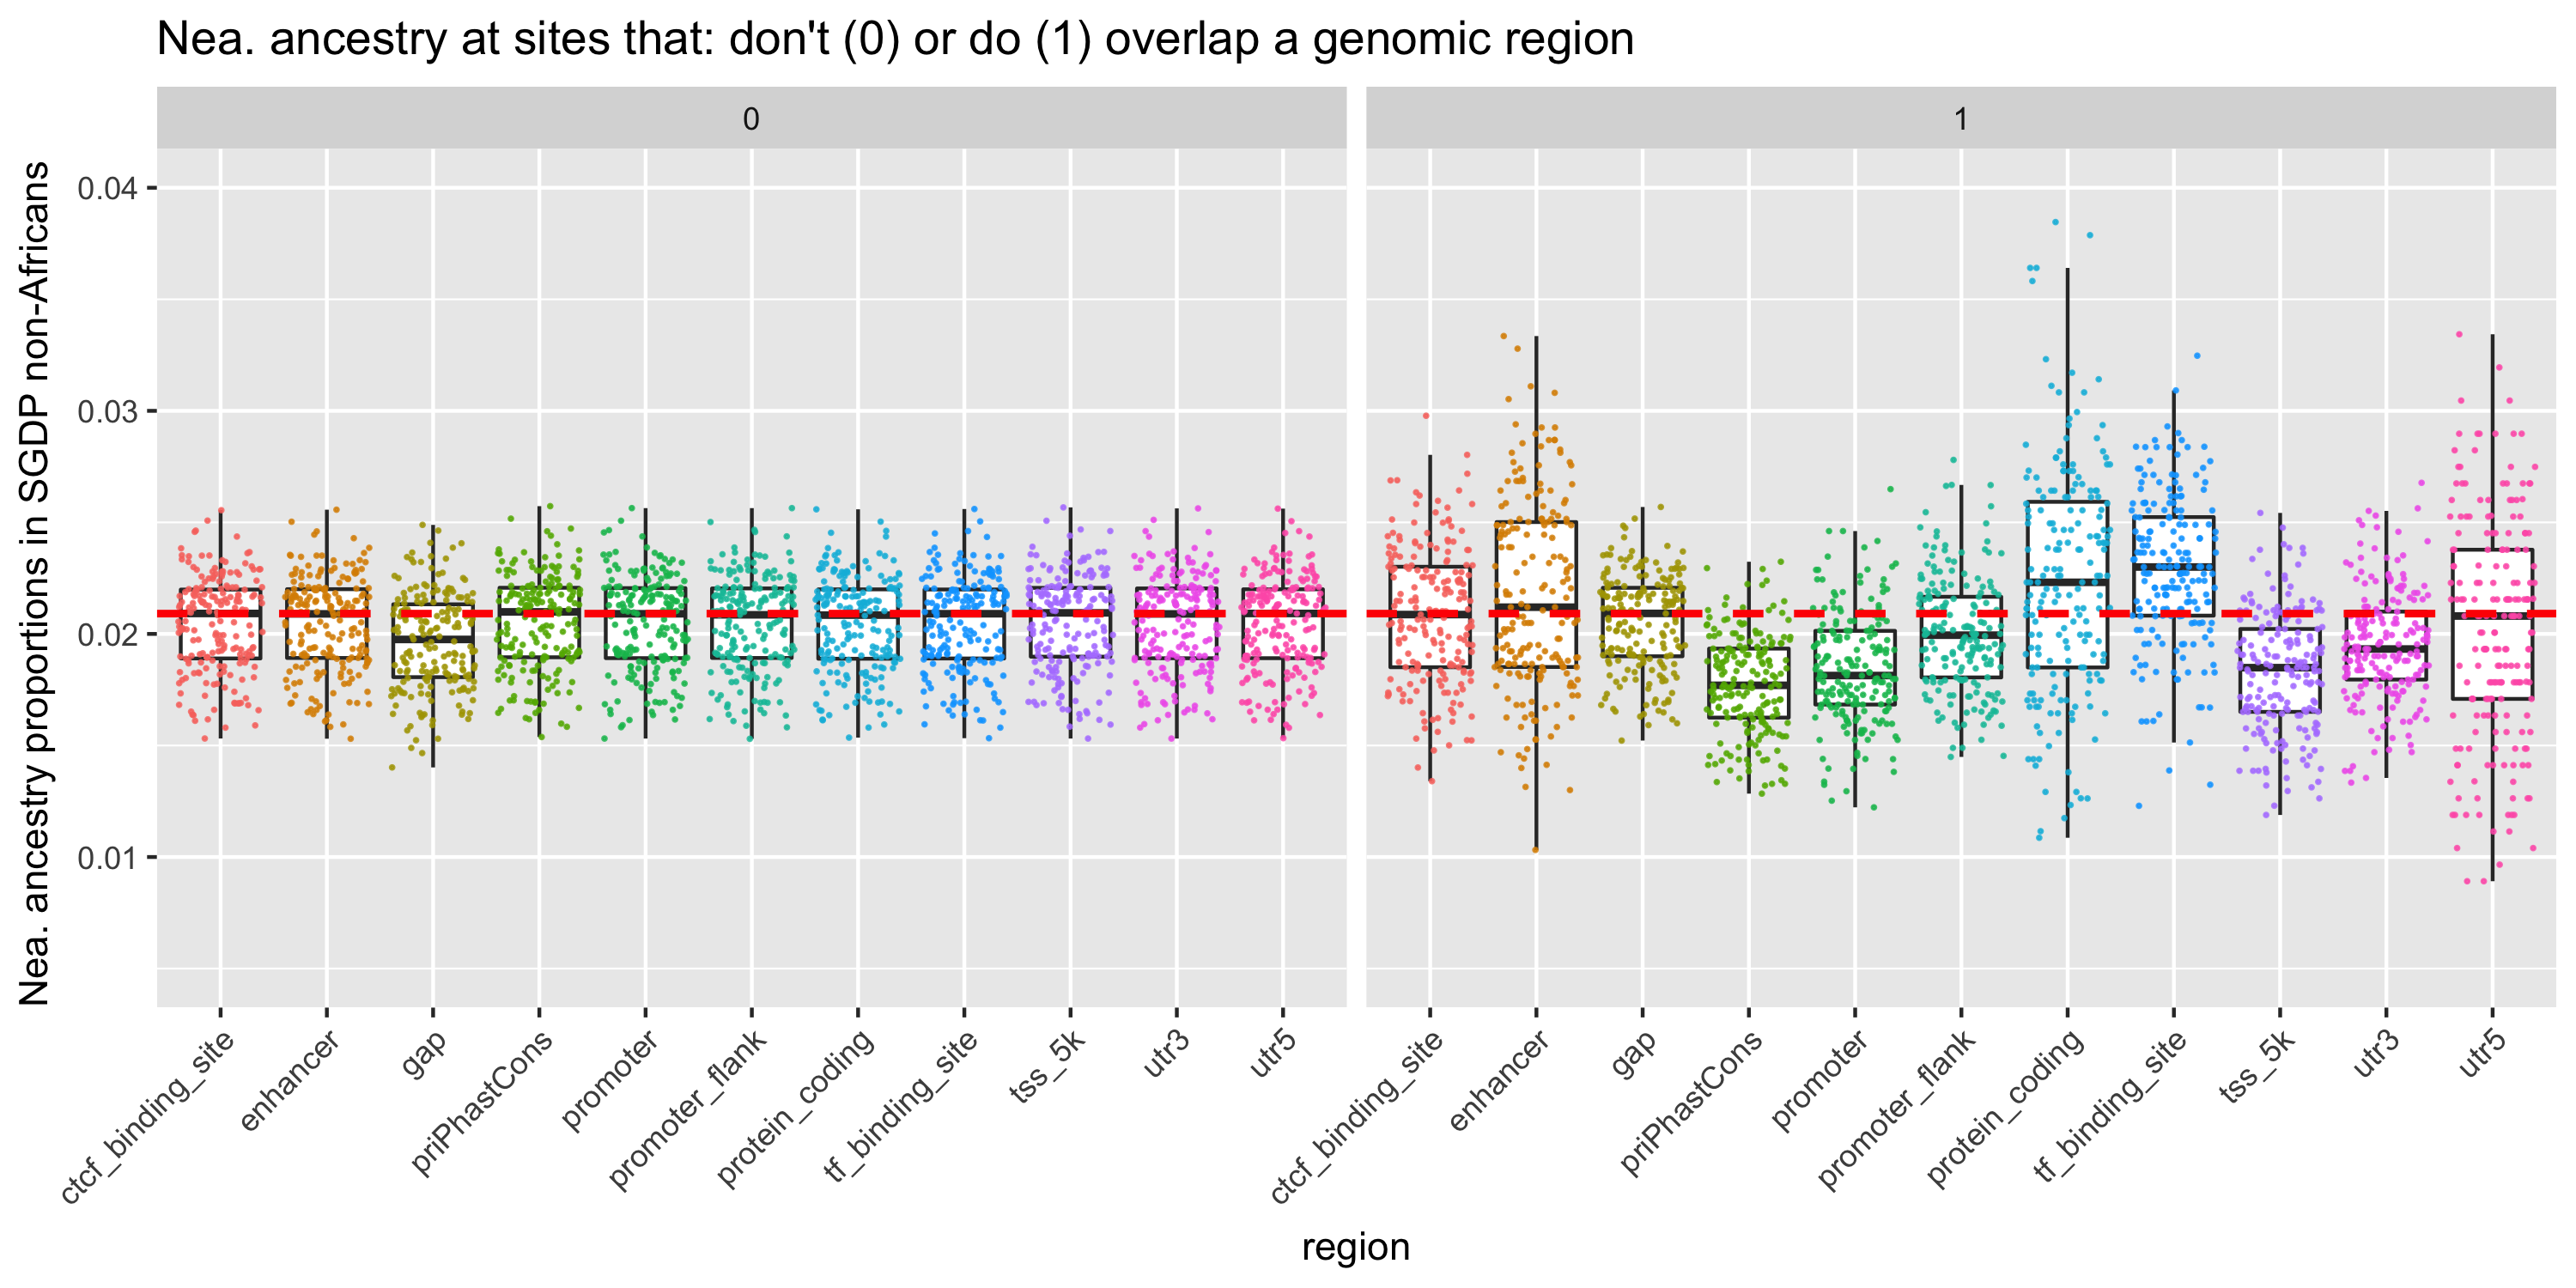

In [73]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

ggplot(nea_in_uniq_regions, aes(region, nea)) +
    geom_boxplot(outlier.size=NA) +
    geom_jitter(aes(color=region), size=0.2, alpha=0.8) +
    geom_hline(yintercept=median(genome_nea_uniq), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region") +
    labs(y="Nea. ancestry proportions in SGDP non-Africans ", "genomic region") +
    ylim(.005, .04)

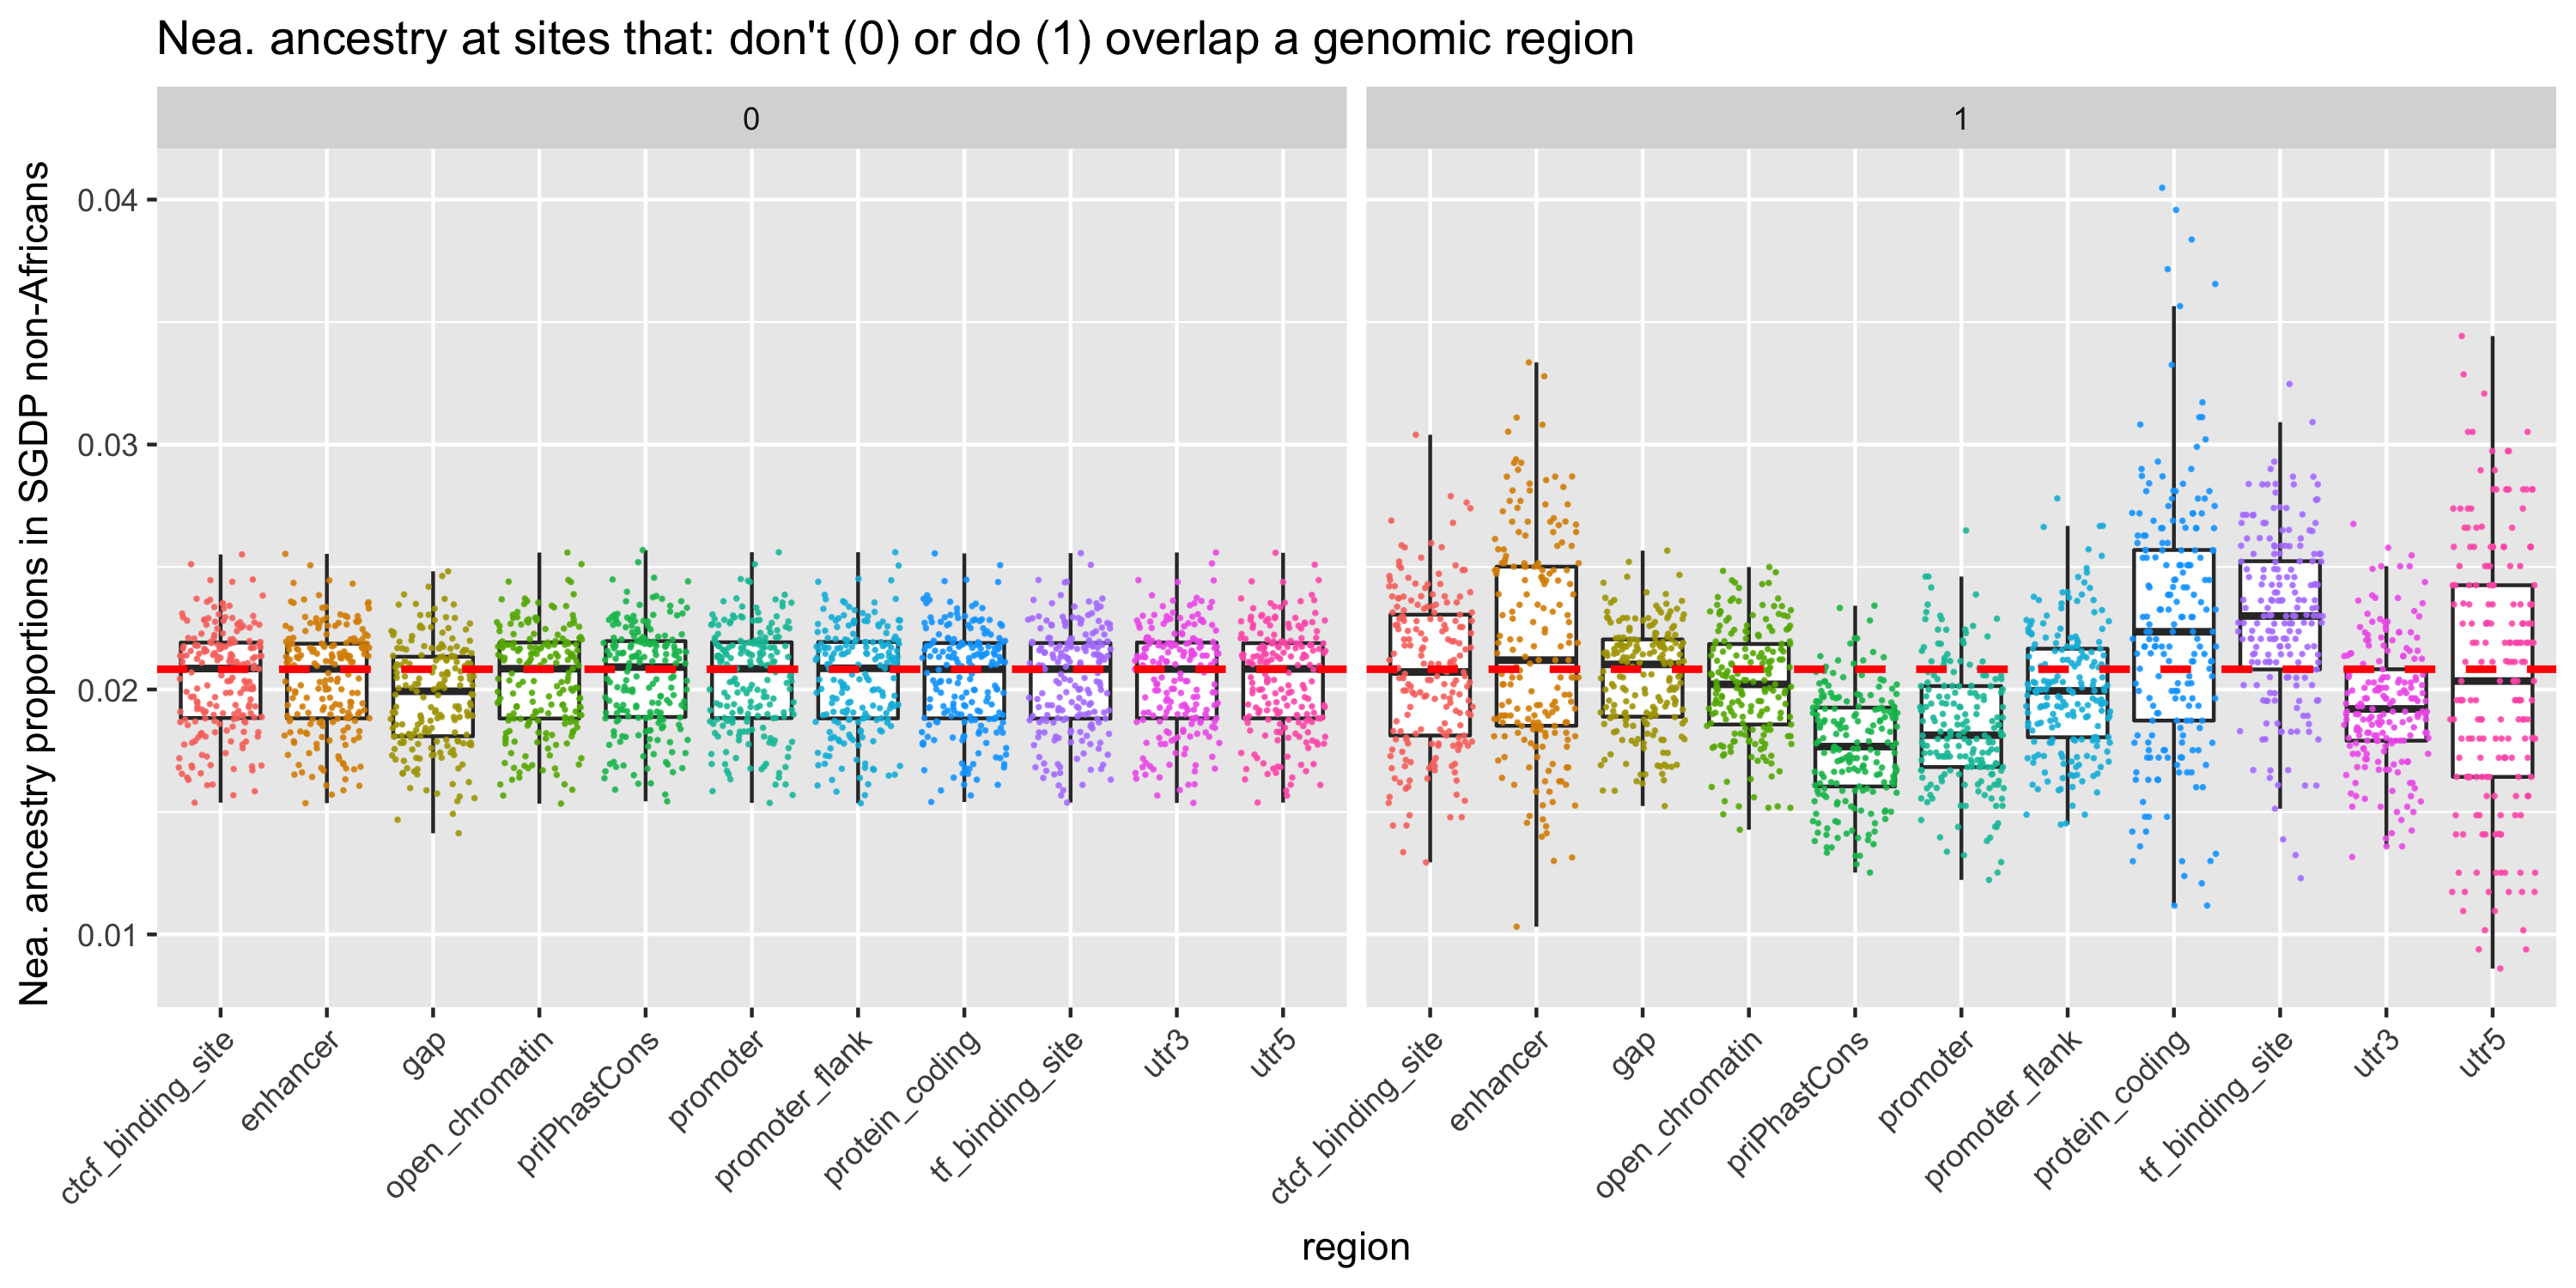

In [26]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

ggplot(nea_in_uniq_regions, aes(region, nea)) +
    geom_boxplot(outlier.size=NA) +
    geom_jitter(aes(color=region), size=0.2, alpha=0.8) +
    geom_hline(yintercept=median(genome_nea_uniq), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region") +
    labs(y="Nea. ancestry proportions in SGDP non-Africans ", "genomic region")

In [30]:
summary(fit <- glm(data=filter(as.data.frame(sites), unique_sites),
                   freq_all > 0 ~ hits_priPhastCons + hits_protein_coding + hits_utr5 + hits_utr3 + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ hits_protein_coding + hits_utr5 + 
    hits_utr3 + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + 
    hits_enhancer + hits_open_chromatin + hits_tf_binding_site, 
    family = "binomial", data = filter(as.data.frame(sites), 
        unique_sites))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.233  -1.190   1.157   1.165   1.251  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.030224   0.003045   9.925  < 2e-16 ***
hits_protein_coding    -0.050769   0.049259  -1.031 0.302705    
hits_utr5              -0.045874   0.079180  -0.579 0.562343    
hits_utr3              -0.088074   0.029550  -2.981 0.002877 ** 
hits_promoter          -0.200948   0.034182  -5.879 4.13e-09 ***
hits_promoter_flank    -0.070840   0.019246  -3.681 0.000233 ***
hits_ctcf_binding_site  0.018207   0.026030   0.699 0.484253    
hits_enhancer           0.010482   0.033769   0.310 0.756244

In [13]:
save.image("../RData/introgression_predictors_unique.RData")

### The same analysis, but now without looking at priPhastCons or 3' UTRs

In [4]:
sample_ids <- filter(samples, pop != "EMH")$name

In [5]:
unique_sites <- (as.data.frame(sites) %>% select(starts_with("hits")) %>% select(-hits_promoter) %>% rowSums) %>% {. == 1 & !is.na(.) }

In [6]:
sum(unique_sites)

[1] 471362

In [7]:
gt_hits <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    select(-hits_promoter) %>% 
    filter(unique_sites) %>%
    gather(region, hits, -c(1:3), -c(S_Chane_1:S_Yemenite_Jew_2)) %>%
    select(-seqnames, -start, -end) %>%
    gather(name, gt, -region, -hits)

Joining, by = c("seqnames", "start", "end")


In [8]:
head(gt_hits)

region              hits name      gt
1 hits_protein_coding 0    S_Chane_1 0 
2 hits_protein_coding 0    S_Chane_1 0 
3 hits_protein_coding 0    S_Chane_1 0 
4 hits_protein_coding 0    S_Chane_1 0 
5 hits_protein_coding 0    S_Chane_1 0 
6 hits_protein_coding 0    S_Chane_1 0

Calculate Nea. ancestry in each individual in different regions of the genome:

In [9]:
hits_nea <-
    group_by(gt_hits, name, region, hits) %>%
    summarise(nea=mean(gt, na.rm=TRUE) / 2) %>%
    ungroup %>% 
    mutate(hits=factor(hits),
           region=str_replace(region, "hits_", ""))

In [10]:
nea_values <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    filter(unique_sites) %>%
    summarise_at(sample_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    t %>% .[, 1]

Joining, by = c("seqnames", "start", "end")


In [11]:
nea_mean <- mean(nea_values)
nea_sd <- sd(nea_values)
nea_n <- length(nea_values)
nea_se <- nea_mean / sqrt(nea_n)
lower_ci <- nea_mean - qt(1 - (0.05 / 2), nea_n - 1) * nea_se
upper_ci <- nea_mean + qt(1 - (0.05 / 2), nea_n - 1) * nea_se

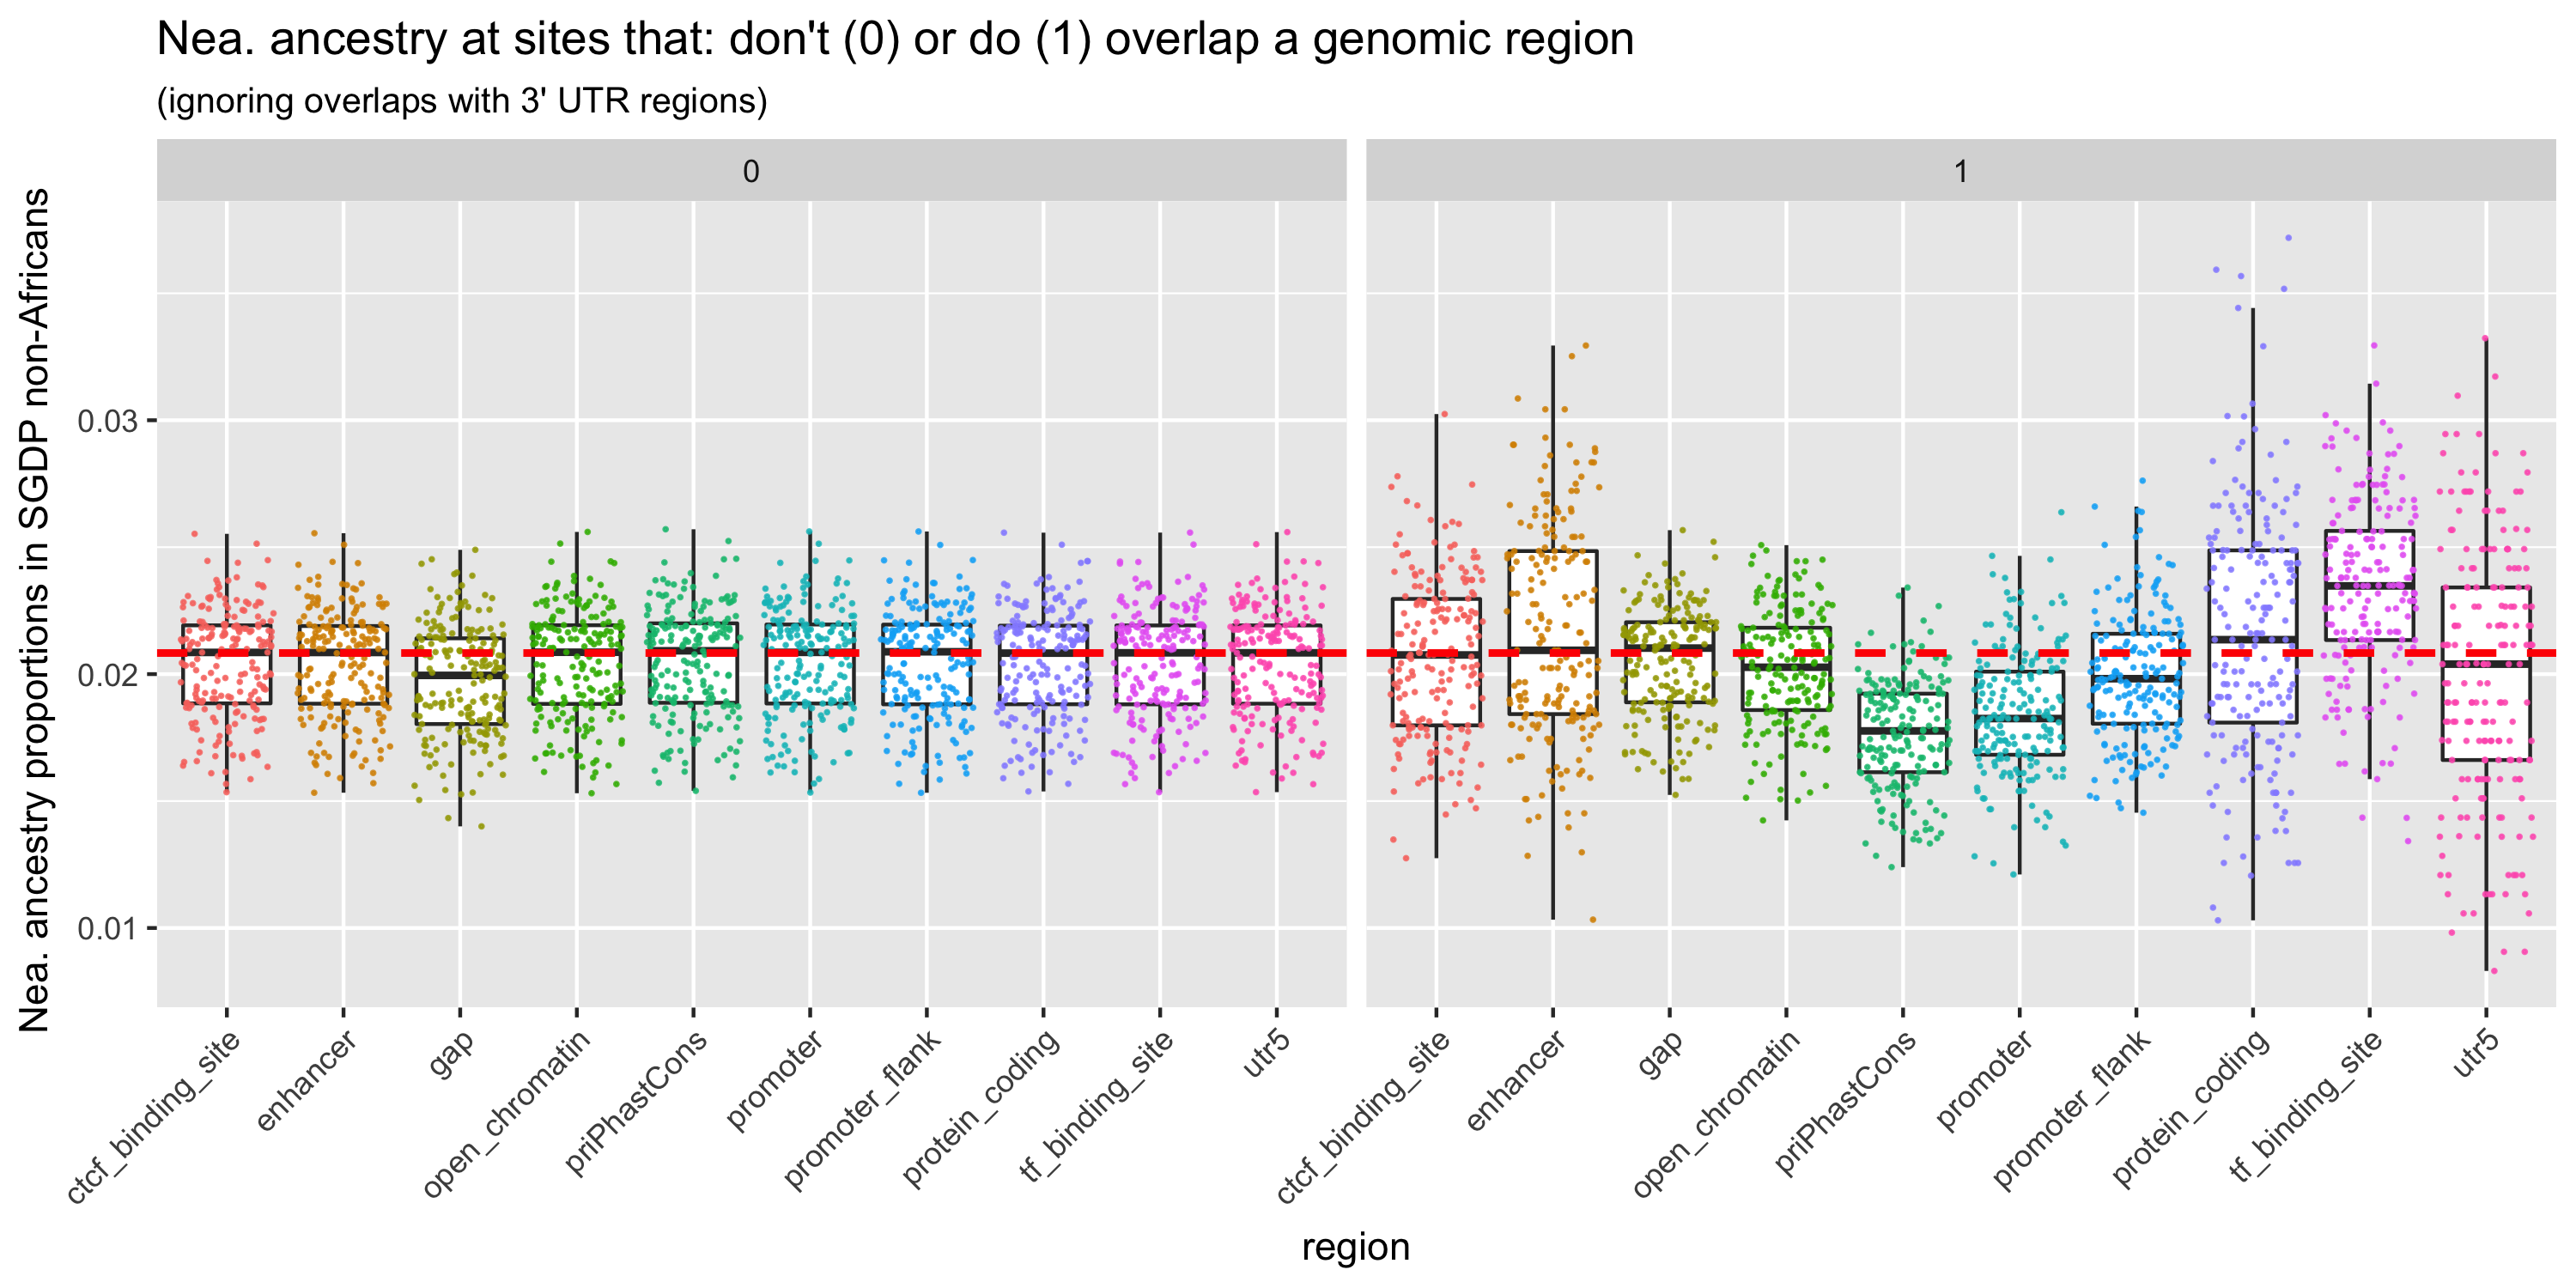

In [12]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

ggplot(hits_nea, aes(region, nea)) +
#    geom_violin(aes(fill=region)) +
#    stat_summary(fun.y="mean", geom="point", size=5, position=position_dodge(width=0.75), color="red") +
    geom_boxplot(outlier.size=NA) +
    geom_jitter(aes(color=region), size=0.2, alpha=0.8) +
    geom_hline(yintercept=median(nea_values), linetype=2, color="red", size=1) +
#    geom_hline(yintercept=lower_ci, linetype=2, color="blue", size=1) +
#    geom_hline(yintercept=upper_ci, linetype=2, color="green", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region",
            "(ignoring overlaps with 3' UTR regions)") +
    labs(y="Nea. ancestry proportions in SGDP non-Africans ", "genomic region")

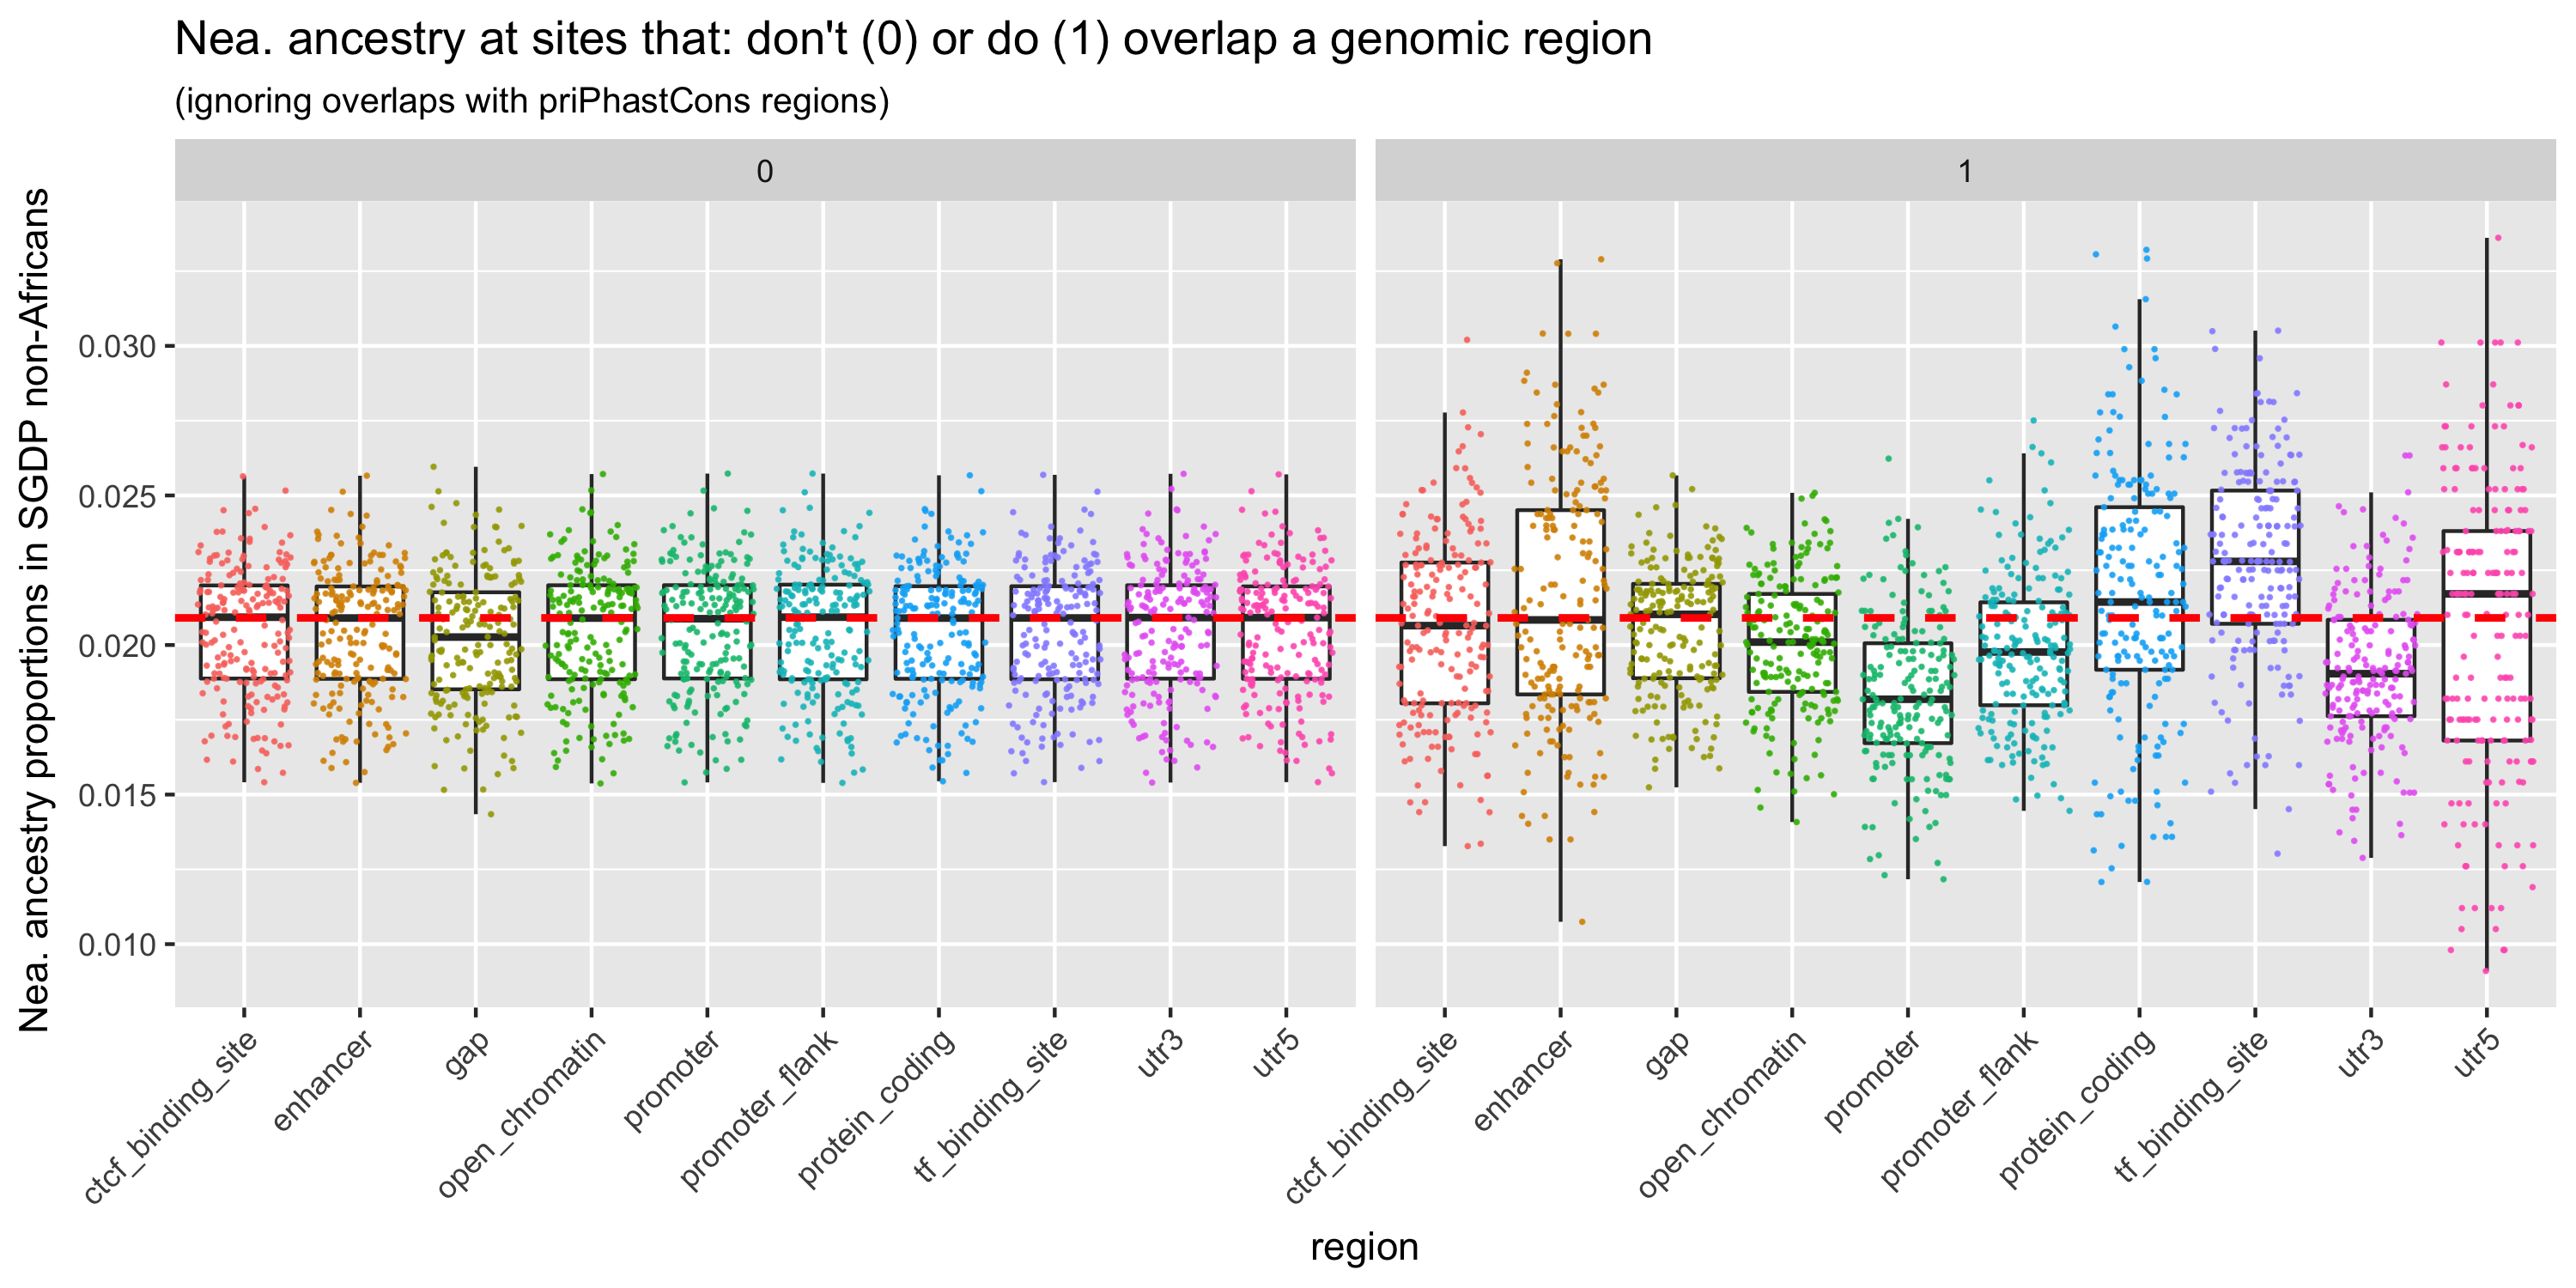

In [13]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

ggplot(hits_nea, aes(region, nea)) +
#    geom_violin(aes(fill=region)) +
#    stat_summary(fun.y="mean", geom="point", size=5, position=position_dodge(width=0.75), color="red") +
    geom_boxplot(outlier.size=NA) +
    geom_jitter(aes(color=region), size=0.2, alpha=0.8) +
    geom_hline(yintercept=median(nea_values), linetype=2, color="red", size=1) +
#    geom_hline(yintercept=lower_ci, linetype=2, color="blue", size=1) +
#    geom_hline(yintercept=upper_ci, linetype=2, color="green", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region",
            "(ignoring overlaps with priPhastCons regions)") +
    labs(y="Nea. ancestry proportions in SGDP non-Africans ", "genomic region")

<br><br><br><br><br><br><br><br><br><br>
## Formally testing the distribution differences

Statistical test to find out whether selection performed differently among different functional categories:

http://rpubs.com/ibecav/308410

### Non-parametric testing - Kruskal-Wallis rank sum test

In [59]:
library(dunn.test)

filter(hits_nea, hits == 1) %>% 
{ dunn.test(.[["nea"]], .[["region"]], method = "holm", alpha = 0.01) }

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 331.8989, df = 10, p-value = 0


                           Comparison of x by group                            
                                    (Holm)                                     
Col Mean-|
Row Mean |   ctcf_bin   enhancer        gap   open_chr   priPhast   promoter
---------+------------------------------------------------------------------
enhancer |  -0.369972
         |     0.3557
         |
     gap |   0.513049   0.883021
         |     0.6079     1.0000
         |
open_chr |   1.679327   2.049299   1.166277
         |     0.5585     0.3032     1.0000
         |
priPhast |   8.956547   9.326519   8.443498   7.277220
         |    0.0000*    0.0000*    0.0000*    0.0000*
         |
promoter |   8.331419   8.701391   7.818369   6.652091  -0.625128
         |    0.0000*    0.0000*    0.0000*    0.0000*     1.0000
         |
promoter |   2.648461   3.018433   2.135411   0.969133  -6.308086  -

<br><br><br><br><br>

## Size of overlaps between each pair of _functional_ genomic regions

I define "functional" functional regions as those that show a significant depletion or enrichment for Nea. ancestry in the logistic regression analysis.

In [68]:
functional_regions <- setdiff(names(regions), "gap")#c("protein_coding", "promoter", "priPhastCons", "utr3", "tf_binding_site")

In [70]:
overlaps <- matrix(rep(NA, length(functional_regions) ^ 2), nrow=length(functional_regions))
colnames(overlaps) <- rownames(overlaps) <- functional_regions

In [71]:
for (r1 in functional_regions) {
    for (r2 in setdiff(functional_regions, r1)) {
        r1_gr <- regions[[r1]]
        r2_gr <- regions[[r2]]

        overlaps[r1, r2] <- sum(width(IRanges::intersect(r1_gr, r2_gr))) / sum(width(r1_gr)) 
    }
}

In [72]:
overlaps

protein_coding utr5        utr3       ctcf_binding_site
protein_coding             NA    0.049916021 0.17361906 0.02761974       
utr5              0.163437583             NA 0.03876457 0.02933340       
utr3              0.156824280    0.010693970         NA 0.02465764       
ctcf_binding_site 0.022672166    0.007354004 0.02240831         NA       
enhancer          0.005358768    0.002750876 0.01342699 0.03359207       
open_chromatin    0.016004941    0.003748712 0.01864558 0.05740711       
promoter          0.076098228    0.182951174 0.01498841 0.01078700       
promoter_flank    0.023632395    0.014825237 0.02073351 0.06344987       
tf_binding_site   0.036599735    0.014430846 0.03130478 0.19587043       
priPhastCons      0.206157596    0.024975639 0.09487306 0.02196613       
                  enhancer      open_chromatin promoter    promoter_flank
protein_coding    0.00289352438 0.0242140282   0.051009628 0.04172216865 
utr5              0.00486345713 0.0185697922   0.401536277 0.08569840606 
utr3              0.00654872449 0.0254803155   0.009075050 0.03306342978 
ctcf_binding_site 0.01488923312 0.0712938466   0.005935422 0.09195243562 
enhancer                     NA 0.0000000000   0.000000000 0.00007655305 
open_chromatin    0.00000000000           NA   0.000000000 0.00039039729 
promoter          0.00000000000 0.0000000000            NA 0.00000000000 
promoter_flank    0.00002341346 0.0003345497   0.000000000            NA 
tf_binding_site   0.00000000000 0.0000000000   0.000000000 0.00221701286 
priPhastCons      0.01449887594 0.0500374739   0.034362939 0.04797958731 
                  tf_binding_site priPhastCons
protein_coding    0.0113411820    0.61536838  
utr5              0.0146414516    0.24409811  
utr3              0.0087620752    0.25579652  
ctcf_binding_site 0.0498221721    0.05382236  
enhancer          0.0000000000    0.08015083  
open_chromatin    0.0000000000    0.09872298  
promoter          0.0000000000    0.15302011  
promoter_flank    0.0003891253    0.08112098  
tf_binding_site             NA    0.08811890  
priPhastCons      0.0091477353            NA

In [18]:
overlaps

cds        promoter   priPhastCons utr3       tf_binding_site
cds                     NA 0.05100963 0.6153684    0.17361906 0.011341182    
promoter        0.07609823         NA 0.1530201    0.01498841 0.000000000    
priPhastCons    0.20615760 0.03436294        NA    0.09487306 0.009147735    
utr3            0.15682428 0.00907505 0.2557965            NA 0.008762075    
tf_binding_site 0.03659973 0.00000000 0.0881189    0.03130478          NA

## Subset of unique regions that show significant Nea. ancestry differences

In [60]:
subset_regions <- regions[c("protein_coding", "promoter", "utr3", "tf_binding_site")]

In [59]:
for (r1 in names(subset_regions)) {
    for (r2 in setdiff(names(subset_regions), r1)) {
        subset_regions[[r1]] <- IRanges::setdiff(subset_regions[[r1]], subset_regions[[r2]])
    }
}

In [60]:
sapply(subset_regions, function(reg) { length(IRanges::subsetByOverlaps(sites, reg)) }) %>% sort

tf_binding_site             cds        promoter            utr3  promoter_flank 
           2257            3649            5189            6404           13208

In [61]:
tibble(
    region=names(subset_regions),
    length=sapply(subset_regions, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6
) %>% arrange(length)

region          length  
1 tf_binding_site 10.48753
2 promoter        22.68667
3 cds             24.74383
4 utr3            35.56222
5 promoter_flank  59.72871

In [62]:
x <- regions

In [63]:
regions <- subset_regions

<br><br><br><br><br><br><br><br><br><br>
# Export coordinates of genomic regions in BED format

In [185]:
sum(width(IRanges::intersect(regions[["protein_coding"]], regions[["promoter"]])))/33844885

[1] 0.05100963

In [187]:
sum(width(IRanges::intersect(regions[["protein_coding"]], regions[["utr3"]])))/33844885

[1] 0.1736191

In [177]:
sum(width(regions[["protein_coding"]]))

[1] 33844885

### Get only nonoverlapping sequences

In [211]:
x <- regions[c("protein_coding", "promoter", "promoter_flank", "utr3", "tf_binding_site")]

In [212]:
for (r1 in names(x)) {
    for (r2 in setdiff(names(x), r1)) {
        x[[r1]] <- IRanges::setdiff(x[[r1]], x[[r2]])
    }
}

In [220]:
tibble(
    region=names(regions),
    length=sapply(regions, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6
)

region            length    
1  cds                19.632317
2  utr5                2.755755
3  utr3               30.486345
4  tss_5k            127.374202
5  ctcf_binding_site  31.593284
6  enhancer           18.273509
7  open_chromatin     51.184259
8  promoter           22.686665
9  promoter_flank     59.728712
10 tf_binding_site    10.487535

In [213]:
tibble(
    region=names(x),
    length=sapply(x, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6
)

region            length    
1  cds                19.632317
2  utr5                2.755755
3  utr3               30.486345
4  tss_5k            127.374202
5  ctcf_binding_site  31.593284
6  enhancer           18.273509
7  open_chromatin     51.184259
8  promoter           22.686665
9  promoter_flank     59.728712
10 tf_binding_site    10.487535

In [192]:
tibble(
    region=names(x),
    length=sapply(x, function(r) { sum(width(IRanges::reduce(r)))}) / 1e6
)

region          length  
1 cds             24.74383
2 promoter        22.34663
3 promoter_flank  58.48984
4 utr3            37.14112
5 tf_binding_site 10.48753

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Archive

### West Eurasians only

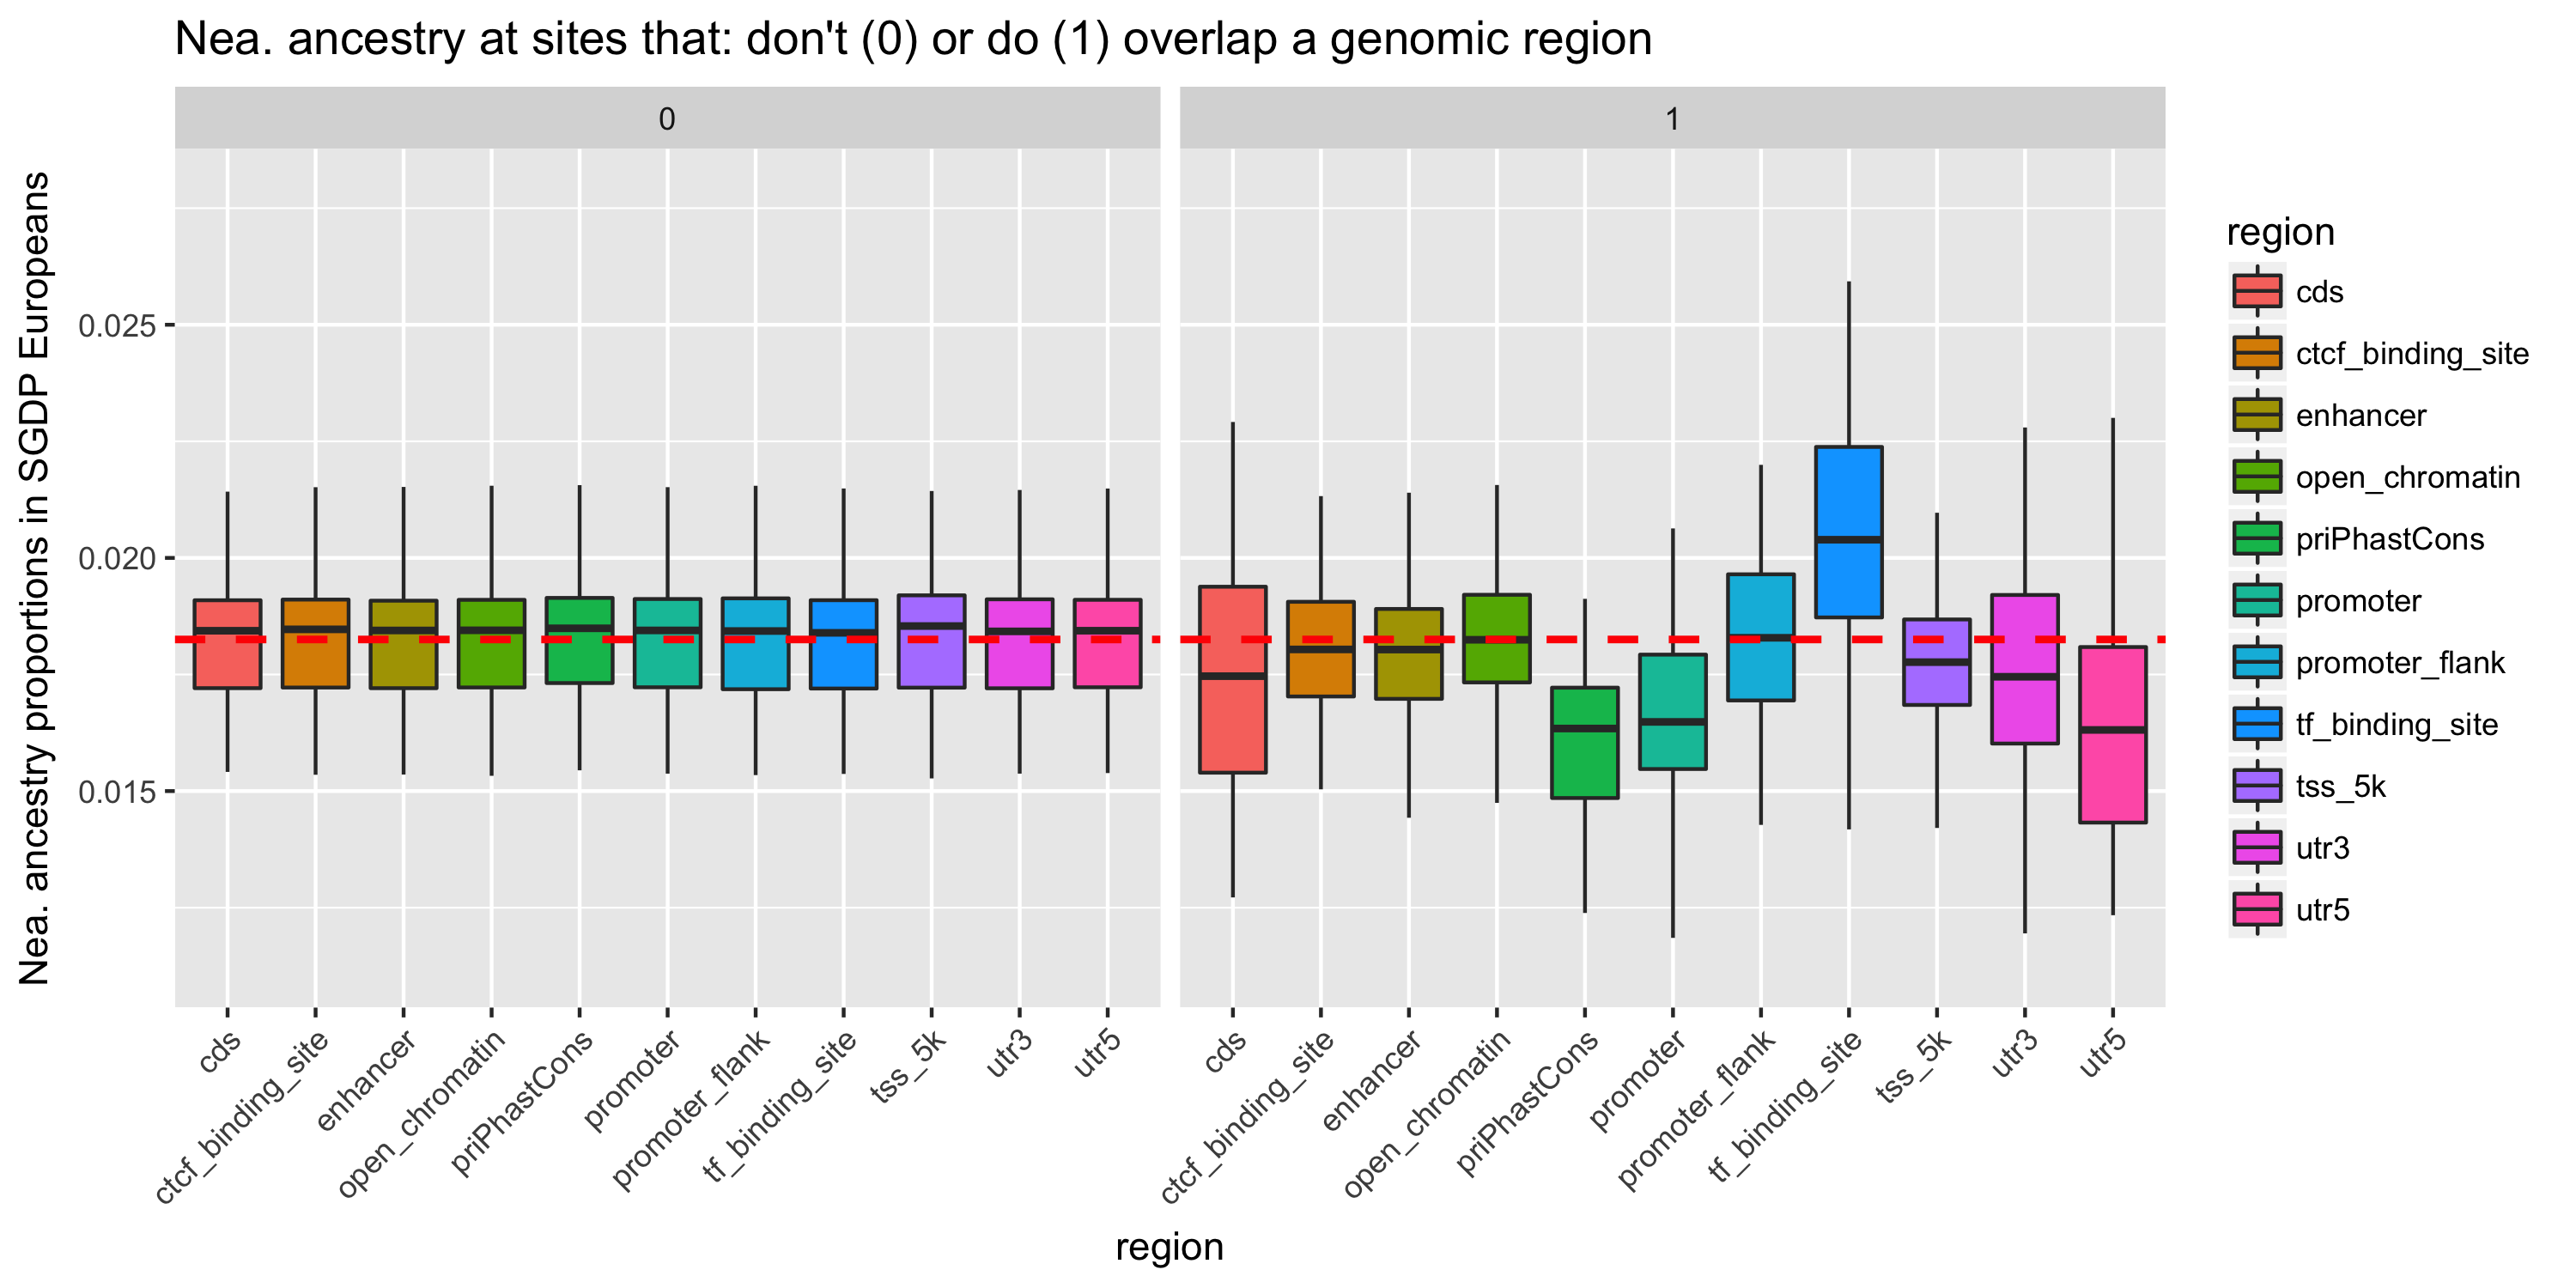

In [101]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

ggplot(bind_rows(hits_nea) %>% filter(complete.cases(.)), aes(region, nea, fill=region)) +
    geom_boxplot(outlier.size=NA) +
    geom_hline(yintercept=mean(genome_wide$nea), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region") +
    labs(y="Nea. ancestry proportions in SGDP Europeans", "genomic region")